In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


Epoch 1/10: 100%|██████████| 938/938 [00:25<00:00, 36.89it/s, loss=56591.2266] 


Epoch 1/10 | Average Loss: 1821.8723


Epoch 2/10: 100%|██████████| 938/938 [00:25<00:00, 37.17it/s, loss=53933.0781] 


Epoch 2/10 | Average Loss: 1752.0548


Epoch 3/10: 100%|██████████| 938/938 [00:25<00:00, 37.10it/s, loss=51919.6406] 


Epoch 3/10 | Average Loss: 1746.0915


Epoch 4/10: 100%|██████████| 938/938 [00:25<00:00, 36.91it/s, loss=59261.0625] 


Epoch 4/10 | Average Loss: 1743.4072


Epoch 5/10: 100%|██████████| 938/938 [00:25<00:00, 36.57it/s, loss=53048.8242] 


Epoch 5/10 | Average Loss: 1741.5994


Epoch 6/10: 100%|██████████| 938/938 [00:25<00:00, 36.23it/s, loss=53810.8438] 


Epoch 6/10 | Average Loss: 1740.3420


Epoch 7/10: 100%|██████████| 938/938 [00:25<00:00, 36.48it/s, loss=53337.4688] 


Epoch 7/10 | Average Loss: 1739.4369


Epoch 8/10: 100%|██████████| 938/938 [00:25<00:00, 36.48it/s, loss=49476.3789] 


Epoch 8/10 | Average Loss: 1738.6538


Epoch 9/10: 100%|██████████| 938/938 [00:25<00:00, 37.12it/s, loss=58472.5430] 


Epoch 9/10 | Average Loss: 1738.0372


Epoch 10/10: 100%|██████████| 938/938 [00:25<00:00, 36.82it/s, loss=52870.2305] 


Epoch 10/10 | Average Loss: 1737.5888


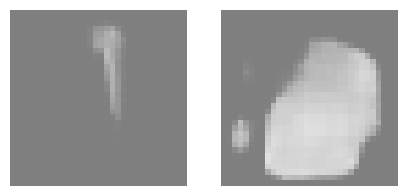

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=3),  #
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = FashionMNIST(root="/kaggle/working/", train=True, transform=transform, download=True)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim, 64 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder_input(z).view(-1, 64, 8, 8)
        return self.decoder(x_recon), mu, logvar

vae = VAE().to(device)
vae_optimizer = optim.Adam(vae.parameters(), lr=0.001)

def train_vae(model, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for batch_idx, (data, _) in enumerate(progress_bar):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} | Average Loss: {avg_loss:.4f}")


train_vae(vae, train_loader, vae_optimizer, epochs=10)


z_vae = torch.randn(2, 20).to(device)
generated_images_vae = vae.decoder(vae.decoder_input(z_vae).view(-1, 64, 8, 8)).detach().cpu()


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow((generated_images_vae[0].permute(1, 2, 0) * 0.5) + 0.5)  # إرجاع القيم إلى النطاق [0,1]
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow((generated_images_vae[1].permute(1, 2, 0) * 0.5) + 0.5)
plt.axis("off")
plt.show()

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 267kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.03MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.8MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Epoch 1/10: 100%|██████████| 938/938 [00:36<00:00, 26.01it/s, D_Loss=0.5239, G_Loss=3.0918]


Epoch 1 | D Loss: 0.5239 | G Loss: 3.0918


Epoch 2/10: 100%|██████████| 938/938 [00:35<00:00, 26.21it/s, D_Loss=0.1316, G_Loss=3.4354]


Epoch 2 | D Loss: 0.1316 | G Loss: 3.4354


Epoch 3/10: 100%|██████████| 938/938 [00:36<00:00, 25.81it/s, D_Loss=0.0513, G_Loss=3.9157] 


Epoch 3 | D Loss: 0.0513 | G Loss: 3.9157


Epoch 4/10: 100%|██████████| 938/938 [00:35<00:00, 26.16it/s, D_Loss=0.0146, G_Loss=5.3186] 


Epoch 4 | D Loss: 0.0146 | G Loss: 5.3186


Epoch 5/10: 100%|██████████| 938/938 [00:35<00:00, 26.44it/s, D_Loss=0.0162, G_Loss=5.1412] 


Epoch 5 | D Loss: 0.0162 | G Loss: 5.1412


Epoch 6/10: 100%|██████████| 938/938 [00:35<00:00, 26.61it/s, D_Loss=0.0170, G_Loss=5.1474] 


Epoch 6 | D Loss: 0.0170 | G Loss: 5.1474


Epoch 7/10: 100%|██████████| 938/938 [00:35<00:00, 26.69it/s, D_Loss=0.5487, G_Loss=4.1977] 


Epoch 7 | D Loss: 0.5487 | G Loss: 4.1977


Epoch 8/10: 100%|██████████| 938/938 [00:35<00:00, 26.68it/s, D_Loss=0.0187, G_Loss=5.4076] 


Epoch 8 | D Loss: 0.0187 | G Loss: 5.4076


Epoch 9/10: 100%|██████████| 938/938 [00:35<00:00, 26.47it/s, D_Loss=1.4342, G_Loss=1.6363] 


Epoch 9 | D Loss: 1.4342 | G Loss: 1.6363


Epoch 10/10: 100%|██████████| 938/938 [00:35<00:00, 26.46it/s, D_Loss=0.5025, G_Loss=5.4379] 


Epoch 10 | D Loss: 0.5025 | G Loss: 5.4379


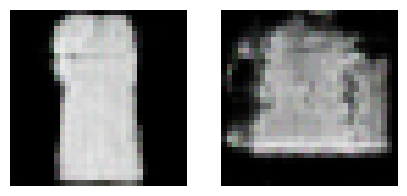

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # خرج بثلاث قنوات (RGB)
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),  
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)


transform = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=3),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

dataset = FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


generator = Generator().to(device)
discriminator = Discriminator().to(device)


criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

def train_dcgan(generator, discriminator, train_loader, epochs=10):
    for epoch in range(epochs):
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for real_images, _ in progress_bar:
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
           
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            
            d_optimizer.zero_grad()
            outputs_real = discriminator(real_images)
            d_real_loss = criterion(outputs_real, real_labels)
            
            z = torch.randn(batch_size, 100, 1, 1).to(device)
            fake_images = generator(z)
            outputs_fake = discriminator(fake_images.detach())
            d_fake_loss = criterion(outputs_fake, fake_labels)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
           
            g_optimizer.zero_grad()
            outputs_fake = discriminator(fake_images)
            g_loss = criterion(outputs_fake, real_labels)
            g_loss.backward()
            g_optimizer.step()
            
            progress_bar.set_postfix(D_Loss=f"{d_loss.item():.4f}", G_Loss=f"{g_loss.item():.4f}")

        print(f"Epoch {epoch+1} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


train_dcgan(generator, discriminator, train_loader, epochs=10)


z = torch.randn(2, 100, 1, 1).to(device)
fake_images = generator(z).cpu().detach()


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(fake_images[0].permute(1, 2, 0) * 0.5 + 0.5)  # تحويل الأبعاد وإعادة تطبيع الصورة
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(fake_images[1].permute(1, 2, 0) * 0.5 + 0.5)  # تحويل الأبعاد وإعادة تطبيع الصورة
plt.axis("off")
plt.show()
